Copyright @ cb_park@korea.ac.kr (Cheonbok Park), joonleesky@kaist.ac.kr (Hojoon Lee)

## Convolutional Neural Network

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
## Below are the all identical neural network with different expression

recap : [link](https://stats.stackexchange.com/questions/295397/what-is-the-difference-between-conv1d-and-conv2d)

output size = `(((W - K + 2P)/S) + 1)`

      - Here W = Input size
      - K = Filter size
      - S = Stride
      - P = Padding 

In [2]:
class CNN1(nn.Module):
    def __init__(self): # input image = batch_size x 3 x 32 x 32
        super(CNN1, self).__init__()
        # in_channels, out_channels, kernel_size, stride=1, padding=0
        self.conv = nn.Conv2d(3, 64, kernel_size=3, padding=1) # todo : check the parameter
        self.relu = nn.ReLU() #
        self.maxpool = nn.MaxPool2d(2) # todo : check the parameter

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        out = self.maxpool(out)
        return out  # input image = batch_size x 3 x 16 x 16

    
class CNN2(nn.Module):
    def __init__(self): # input image = batch_size x 3 x 32 x 32
        super(CNN2, self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))

    def forward(self, x):
        out = self.layer(x)
        return out  # input image = batch_size x 3 x 16 x 16      
      

class CNN3(nn.Module):
    def __init__(self): # input image = batch_size x 3 x 32 x 32
        super(CNN3, self).__init__()
        layer = []
        
        layer.append(nn.Conv2d(3, 64, kernel_size=3, padding=1))
        layer.append(nn.ReLU())
        layer.append(nn.MaxPool2d(2))
        
        self.layer = nn.Sequential(*layer)

    def forward(self, x):
        out = self.layer(x)
        return out  # input image = batch_size x 3 x 16 x 16

In [5]:
sample_image = torch.zeros(16, 3, 32, 32) # batch. 3 x H x W

In [6]:
cnn = CNN1()
print(cnn)
output = cnn(sample_image) # 16. 64. 32. 32.
print(output.size())

CNN1(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([16, 64, 16, 16])


In [7]:
cnn = CNN2()
print(cnn)
output = cnn(sample_image)
print(output.size())

CNN2(
  (layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([16, 64, 16, 16])


In [8]:
cnn = CNN3()
print(cnn)
output = cnn(sample_image)
print(output.size())

CNN3(
  (layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([16, 64, 16, 16])


### Let's practice creating the Convolutional Neural Network

In [17]:
class CNN_prac(nn.Module):
    def __init__(self): # input image = batch_size x 3 x 32 x 32
        super(CNN_prac, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...)
        self.conv1 = nn.Conv2d(3, 512, 3, 1, 1)  # expected output shape : [batch, 512, 32, 32]
        self.conv2 = nn.Conv2d(512, 256, 3, 1, 1) # expected output shape : [batch, 256, 32, 32]
        self.conv3 = nn.Conv2d(256, 256, 3, 2, 1) # expected output shape : [batch, 256, 16, 16]
        self.conv4 = nn.Conv2d(256, 256, 3, 4, 1) # todo : change to nn.Conv2d(?, ?, ?, ?, ?) (((W - K + 2P)/S) + 1)

        self.linear = nn.Linear(256*4*4, 10)
    def forward(self, x):
        out=self.conv1(x)
        out=self.conv2(out)
        out=self.conv3(out)
        out=self.conv4(out)
        # contiguous : 연속적인 메모리 공간 할당(효율적인 메모리 할당)
        out = out.contiguous().view(-1, 256*4*4) # output size should be [batch, 256, 4, 4]
        out = self.linear(out)
        return out

In [18]:
cnn_prac=CNN_prac()
sample_image = torch.zeros(64, 3, 32, 32)
output=cnn_prac(sample_image)
print(output.size()) 
print(cnn_prac)

torch.Size([64, 10])
CNN_prac(
  (conv1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
  (linear): Linear(in_features=4096, out_features=10, bias=True)
)


## 2.1 VGG-19

### Let's create by yourself

In [20]:
# https://iq.opengenus.org/vgg19-architecture/
# ConvBlock1 : [conv -> batchnorm -> relu] x 2
class ConvBlock1(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(ConvBlock1, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.main = nn.Sequential(nn.Conv2d(self.in_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2)
                                 )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [21]:
# ConvBlock2 : [conv -> batchnorm -> relu] x 4
class ConvBlock2(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(ConvBlock2, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.main = nn.Sequential(nn.Conv2d(self.in_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),                    
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2) 
                                 )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [22]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        
        self.convlayer1 = ConvBlock1(3, 64)
        self.convlayer2 = ConvBlock1(64, 128)
        self.convlayer3 = ConvBlock2(128, 256)
        self.convlayer4 = ConvBlock2(256, 512)
        self.convlayer5 = ConvBlock2(512, 512)
        self.linear = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    def forward(self, input):
        out = self.convlayer1(input)    
        out = self.convlayer2(out)
        out = self.convlayer3(out)
        out = self.convlayer4(out)
        out = self.convlayer5(out).squeeze() # 16 x 512 x 1 x 1에서 뒤 1 x 1 축약 
        out = self.linear(out)
        return out


## Test Your Impelemetation

In [23]:
vgg19 = VGG19()
print(vgg19)

output = vgg19(sample_image)
print(output.size())

VGG19(
  (convlayer1): ConvBlock1(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (convlayer2): ConvBlock1(
    (main): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2,

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
if count_parameters(vgg19) == 20365002:
    print('success!')

success!


# 2.2 CIFAR-10 Dataset

50000 training images  \
10000 validation images \
\
10 classes = [airplane, car, truck, frog, ...]
\
for more info, https://www.cs.toronto.edu/~kriz/cifar.html 



In [27]:
# colab에서 상대경로를 이용하기 위한 코드. 과제 시연땐 무시해주세요
from google.colab import drive
import os


drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/수업/20211224(CNN)') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# set hyperparameters
batch_size = 64
learning_rate = 0.0001
num_epochs = 1

In [105]:
# import torchvision.datasets as datasets

train_dataset = datasets.CIFAR10(root='./data/',       # 50000장
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = datasets.CIFAR10(root='./data/',        # 10000장
                           train=False, 
                           transform=transforms.ToTensor())

# 데이터 로더
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

Files already downloaded and verified


In [89]:
import matplotlib.pyplot as plt
import numpy as np


def show_cifar10():
    for images, _ in train_loader:
        plt.figure(figsize=(8,8))
        images_to_show = images.numpy().transpose((0,2,3,1))

        for a in range(331, 340):  
            plt.subplot(a)
            plt.imshow(images_to_show[a-331])
            plt.xticks([])
            plt.yticks([])    
            plt.show()   
        break
    return 0


def loss_plot(acc):  
    plt.plot(acc)
    plt.xlabel('log')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.show()
    return 0

import time
class Timer():    
    def __init__(self):
        self.cur_t = time.time()

    def tic(self):
        self.cur_t = time.time()

    def toc(self):
        return time.time() - self.cur_t

    def tocStr(self, t=-1):
        if (t == -1):
            return str(datetime.timedelta(seconds=np.round(time.time() - self.cur_t, 3)))[:-4]
        else:
            return str(datetime.timedelta(seconds=np.round(t, 3)))[:-4]
          

def test_on_cifar10(model, accuracy_list):  
    # Test the Model       
    model.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    for j, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
        if (j+1)%100==0:
            break

    print('Test Accuracy of the model on the 100 test images: %d %%' % (100 * correct.float() / total))
    accuracy_list.append(100 * correct.float() / total) 
    return accuracy_list

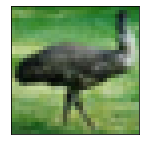

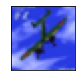

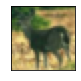

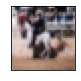

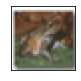

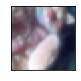

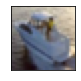

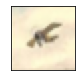

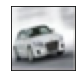

0

In [31]:
show_cifar10()

## Train Cifar-10 with your VGG-19

Epoch [1/1], Iter [100/781] Loss: 2.0960, iter_time: 21.95
Test Accuracy of the model on the 100 test images: 23 %
Epoch [1/1], Iter [200/781] Loss: 1.9329, iter_time: 27.27
Test Accuracy of the model on the 100 test images: 30 %
Epoch [1/1], Iter [300/781] Loss: 1.8100, iter_time: 27.28
Test Accuracy of the model on the 100 test images: 37 %
Epoch [1/1], Iter [400/781] Loss: 1.7002, iter_time: 27.27
Test Accuracy of the model on the 100 test images: 38 %
Epoch [1/1], Iter [500/781] Loss: 1.5990, iter_time: 27.27
Test Accuracy of the model on the 100 test images: 43 %
Epoch [1/1], Iter [600/781] Loss: 1.2822, iter_time: 27.28
Test Accuracy of the model on the 100 test images: 40 %
Epoch [1/1], Iter [700/781] Loss: 1.6012, iter_time: 27.33
Test Accuracy of the model on the 100 test images: 45 %


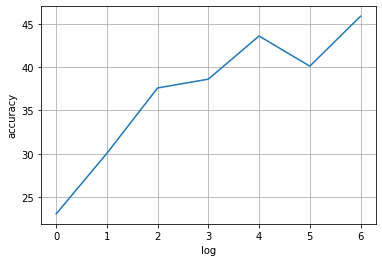

In [90]:
import torchvision.models as models
vgg19 = models.vgg19_bn(pretrained=False)

tell_time = Timer()
iter_time = 0

vgg19 = vgg19.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg19.parameters(), lr=learning_rate)

accuracy_list = []
for epoch in range(num_epochs):
    vgg19.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = vgg19(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, iter_time: %2.2f' 
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()    
            accuracy_list = test_on_cifar10(vgg19, accuracy_list)

    loss_plot(accuracy_list)

## Train Cifar-10 with pre-trained VGG-19

In [92]:
import torchvision.models as models
pre_vgg=models.vgg19_bn(pretrained=True)

In [93]:
pre_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [94]:
a = torch.zeros((4,3,32,32))
pre_vgg.features(a).shape

torch.Size([4, 512, 1, 1])

In [95]:
class pretrained_vgg(nn.Module):
    def __init__(self, pre_vgg):
        super(pretrained_vgg, self).__init__()
        self.features = nn.Sequential(   
            *list(pre_vgg.features.children())
        )
        self.linear = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    def forward(self, x):
        out = self.features(x).squeeze()
        out = self.linear(out)
        return out

Epoch [1/1], Iter [100/781] Loss: 0.9402, iter_time: 11.93
Test Accuracy of the model on the 100 test images: 69 %
Epoch [1/1], Iter [200/781] Loss: 0.7927, iter_time: 15.87
Test Accuracy of the model on the 100 test images: 73 %
Epoch [1/1], Iter [300/781] Loss: 0.7378, iter_time: 15.87
Test Accuracy of the model on the 100 test images: 75 %
Epoch [1/1], Iter [400/781] Loss: 0.5879, iter_time: 15.87
Test Accuracy of the model on the 100 test images: 81 %
Epoch [1/1], Iter [500/781] Loss: 0.4533, iter_time: 15.85
Test Accuracy of the model on the 100 test images: 81 %
Epoch [1/1], Iter [600/781] Loss: 0.4639, iter_time: 15.85
Test Accuracy of the model on the 100 test images: 80 %
Epoch [1/1], Iter [700/781] Loss: 0.5240, iter_time: 15.85
Test Accuracy of the model on the 100 test images: 84 %


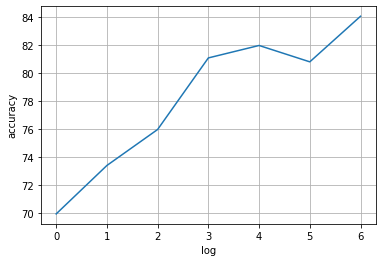

In [36]:
vgg19 = pretrained_vgg(pre_vgg)

tell_time = Timer()
iter_time = 0

vgg19 = vgg19.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg19.parameters(), lr=learning_rate)

accuracy_list = []
for epoch in range(num_epochs):
    vgg19.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = vgg19(images) # batch, 10
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, iter_time: %2.2f' 
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()    
            accuracy_list = test_on_cifar10(vgg19, accuracy_list)

    loss_plot(accuracy_list)

# ASSIGNMENT : Change the vgg model to resnet model and re-training

In [160]:
# https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
resnet18 = models.resnet18(pretrained=True)

In [161]:
a = torch.zeros((64,3,32,32))
o = resnet18(a)
print(o.shape)

torch.Size([64, 1000])


In [162]:
# hint !!!
test_layers = nn.Sequential(   
            *list(resnet18.children())
        )
for i in range(len(test_layers)):
    o = test_layers[:i](a)
    print(i, o.shape)

0 torch.Size([64, 3, 32, 32])
1 torch.Size([64, 64, 16, 16])
2 torch.Size([64, 64, 16, 16])
3 torch.Size([64, 64, 16, 16])
4 torch.Size([64, 64, 8, 8])
5 torch.Size([64, 64, 8, 8])
6 torch.Size([64, 128, 4, 4])
7 torch.Size([64, 256, 2, 2])
8 torch.Size([64, 512, 1, 1])
9 torch.Size([64, 512, 1, 1])


In [163]:
test_layers

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [165]:
class pretrained_resnet(nn.Module):
    def __init__(self, resnet18):
        super(pretrained_resnet, self).__init__()
        self.features = nn.Sequential(   
            *list(resnet18.children())
        )
        self.features = self.features[:7]

        self.linear = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    
    def forward(self, x):
        out = self.features(x).view(-1, 256 * 2 * 2)
        out = self.linear(out)
        return out

In [166]:
# set hyperparameters
learning_rate = 0.00005
num_epochs = 2

Epoch [1/2], Iter [100/781] Loss: 1.8220, iter_time: 3.45
Test Accuracy of the model on the 100 test images: 43 %
Epoch [1/2], Iter [200/781] Loss: 1.1620, iter_time: 5.20
Test Accuracy of the model on the 100 test images: 63 %
Epoch [1/2], Iter [300/781] Loss: 0.7695, iter_time: 5.23
Test Accuracy of the model on the 100 test images: 69 %
Epoch [1/2], Iter [400/781] Loss: 0.7130, iter_time: 5.23
Test Accuracy of the model on the 100 test images: 72 %
Epoch [1/2], Iter [500/781] Loss: 0.7716, iter_time: 5.24
Test Accuracy of the model on the 100 test images: 73 %
Epoch [1/2], Iter [600/781] Loss: 0.8081, iter_time: 5.22
Test Accuracy of the model on the 100 test images: 74 %
Epoch [1/2], Iter [700/781] Loss: 0.7579, iter_time: 5.22
Test Accuracy of the model on the 100 test images: 75 %


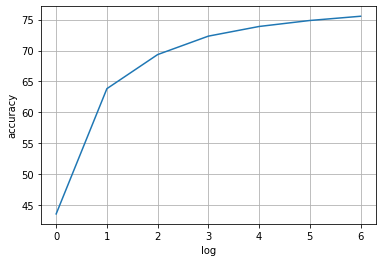

Epoch [2/2], Iter [100/781] Loss: 1.2831, iter_time: 8.07
Test Accuracy of the model on the 100 test images: 71 %
Epoch [2/2], Iter [200/781] Loss: 0.8056, iter_time: 5.22
Test Accuracy of the model on the 100 test images: 76 %
Epoch [2/2], Iter [300/781] Loss: 0.8351, iter_time: 5.25
Test Accuracy of the model on the 100 test images: 77 %
Epoch [2/2], Iter [400/781] Loss: 0.6325, iter_time: 5.24
Test Accuracy of the model on the 100 test images: 77 %
Epoch [2/2], Iter [500/781] Loss: 0.6044, iter_time: 5.23
Test Accuracy of the model on the 100 test images: 76 %
Epoch [2/2], Iter [600/781] Loss: 0.6497, iter_time: 5.26
Test Accuracy of the model on the 100 test images: 76 %
Epoch [2/2], Iter [700/781] Loss: 0.6343, iter_time: 5.25
Test Accuracy of the model on the 100 test images: 77 %


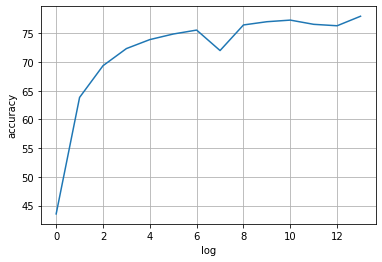

In [167]:
resnet_our = pretrained_resnet(resnet18)

tell_time = Timer()
iter_time = 0

resnet_our = resnet_our.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_our.parameters(), lr=learning_rate)

accuracy_list = []
for epoch in range(num_epochs):
    resnet_our.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = resnet_our(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, iter_time: %2.2f' 
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()    
            accuracy_list = test_on_cifar10(resnet_our, accuracy_list)

    loss_plot(accuracy_list)